In [130]:

import random
import matplotlib.pyplot as plt
import math
import numpy as np


# Homogenous case : 
p and alpha are the same for each players

In [257]:
class Individual:
    def __init__(self, Initialwealth, riskCurve, alpha,index):
        self.Initialwealth = Initialwealth #wealth
        self.wealth = Initialwealth
        self.riskCurve = riskCurve 
        self.alpha = alpha #fraction lost during bad event
        self.behaviour = None #Initialized randomly when a simulation is launched
        self.contribution = []
        self.finalWealthHistory = []
        self.index = index
        self.fitness = None
        
    def __repr__(self):
        #To output a string representaion of the object
        return ('Individual {}, behaviour : {}'.format(self.index,str(self.behaviour)))
    

 
    def generateRandomBehaviour(self,numberOfRounds):
        #instanciate a random behaviour
        #self.behaviour = [[round(random.random(),2),round(random.random(),2),round(random.random(),2)] for i in range(numberOfRounds)]
        self.behaviour = [[round(random.random(),2),i/numberOfRounds,i/numberOfRounds] for i in range(numberOfRounds)]
        
    def setFitnessValue(self):
        #to calculate the fitness value a the end of a generation (usefull to render new population)
        self.fitness =  np.exp(np.mean(self.finalWealthHistory))
        
    def Contribution(self, Cr,nround):
        beh= self.behaviour[nround]
        if(Cr<=beh[0]):
            return beh[1]
        else:
            return beh[2]
        

    
    def Step(self, Cr ,nround):
        #amount contributed to public good
        c = self.Contribution(Cr,nround)
        contribution = c*self.wealth
        #calculate what's left of wealth
        return c, contribution
    
    def addFinalWealthToHistory(self):
        #to add the ramaining wealth at the end of a game, the the mean is done to calculate the fitness at the end of a generation
        self.finalWealthHistory.append(self.wealth)
        
    def resetRound(self):
        self.wealth = self.Initialwealth

        
def risk(Cr,riskCurve):#chance of having bad event happening
    #this are not the right curve TODO!!
    p1 = lambda Cr :1 -Cr
    p2 = lambda Cr: 1-10*Cr if Cr<0.1 else 0
    p3 = lambda Cr : 1-math.pow(Cr,4)
    p4 = lambda Cr: 1/(math.exp(10*((Cr)-0.5))+1)
    dic = {'linear':p1,'piecewiseLinear':p2,'powerlaw':p3,'treshold':p4}

    if (random.random() < dic[riskCurve](Cr)):
        return 1
    return 0


In [252]:
ind1 = Individual(100,'linear',0.1,1)
ind2 = Individual(100,'linear',0.1,1)
ind1.generateRandomBehaviour(2)
ind2.generateRandomBehaviour(2)
print(ind1.behaviour)
print(ind2.behaviour)
ind1.Step(0,0)



[[0.42, 0.0, 0.0], [0.32, 0.5, 0.5]]
[[0.57, 0.0, 0.0], [0.54, 0.5, 0.5]]


(0.0, 0.0)

In [239]:
ind2.Step(0,0)

(0.82, 82.0)

yo


(0.39, 0.5576923169999995)

In [260]:
class Simulation:
    def __init__(self,numberOfRounds,wealth,alpha,riskCurve,populationSize,numberOfGamesByGenerations,numberOfGenerations,mu,sigma):
        self.numberOfRounds = numberOfRounds
        self.numberOfGamesByGenerations = numberOfGamesByGenerations
        self.numberOfGenerations = numberOfGenerations
        self.wealth = wealth 
        self.alpha = alpha
        self.riskCurve = riskCurve
        self.populationSize = populationSize
        #create the first population
        self.population = self.createRandomPopulation()
        self.mu = mu
        self.sigma = sigma
        
    def createRandomPopulation(self):
        #create the first population
        population = [Individual(self.wealth,self.riskCurve,self.alpha,i) for i in range(self.populationSize)]
        for individual in population:
            #initialize the behaviour (lenght = numberofRounds)
            individual.generateRandomBehaviour(self.numberOfRounds)
        return population
    
    def renewPopulation(self):
        fitness = [individual.fitness for individual in self.population]
        fitprop = fitness/np.sum(fitness)
        numoffspring = np.random.multinomial(self.populationSize, fitprop)
        newbehaviours = []
        for individual, num in zip(self.population, numoffspring):
            newbehaviours.extend([individual.behaviour]*num)
        population = [Individual(self.wealth,self.riskCurve,self.alpha,i) for i in range(self.populationSize)]
        for i in range(self.populationSize):
            population[i].behaviour = newbehaviours[i]
            
        
        
        
    
    def playGame(self,players):
        #play a game between two players (or more)
        Cr = 0 # initial public good 
        temp = 0
        contributions=np.empty((len(players),self.numberOfRounds))
        for nround in range(self.numberOfRounds):
            c= []
            for i in range(len(players)):
                cc, co =  players[i].Step(Cr,nround)
                contributions[i,nround]=co
                c.append(cc)
            Cr +=temp
            for i in range(len(players)):
                players[i].wealth = (1-self.alpha*risk(Cr,self.riskCurve))*(players[i].wealth*(1-c[i]))
                        
        for i in range(len(players)):
            players[i].contribution.append(np.sum(contributions[i])/100)
       

        
        for player in players:
            player.addFinalWealthToHistory()
            player.resetRound()
            
        
    
    def playGeneration(self):
        #for a certain number of iteration 2 players are selected randomly and the play a game
        for i in range(self.numberOfGamesByGenerations):
            players = np.random.choice(self.population,2,replace=False)
            '''
            if (i%500 == 0):
                print("game : {}, player 1 : {}, player 2 : {}".format(i,players[0],players[1]))
            '''
            self.playGame(players)
            '''
            if (i%500 == 0):
                print("wealth player 1 : {},wealth player 2 : {}".format(players[0].finalWealthHistory[-1],players[1].finalWealthHistory[-1]))
            '''
    def wrightFisher(self):
        self.renewPopulation()
        for individual in self.population:
            if random.random()<self.mu:
                for elem in individual.behaviour:
                    elem[0] += np.random.normal(0,self.sigma)
            if random.random()<self.mu:
                for elem in individual.behaviour:
                    elem[1] = np.random.uniform(0,1)
                    elem[2] = np.random.uniform(0,1)
    
    def runSim(self):
        #lauch a simulation 
        for i in range(self.numberOfGenerations):
            if (i%20 ==0):
                print("----------Generation",i)   
            self.playGeneration()
            contributionValues =[]
            for individual in self.population:
                individual.setFitnessValue()
                mean = np.mean(individual.contribution)
                contributionValues.append(mean)
            if (i%20 ==0):
                print('contribution :', np.mean(contributionValues))
            self.wrightFisher()  
        print(self.population[2].behaviour)


        
        
    
        
        
            
        
    

In [262]:
sim = Simulation(1,100,0,'linear',100,1000,100,0.03,0.15)
sim.runSim()



----------Generation 0
contribution : 0.0
----------Generation 20
contribution : 0.081794398195
----------Generation 40
contribution : 0.156392443952
----------Generation 60
contribution : 0.216779866356
----------Generation 80
contribution : 0.258712875741
[[0.5093287054526536, 0.8932956551413463, 0.6486931034492297]]


>>>>Round :  1 <<<<<
Wealth 0.81 contribution 0.1
Wealth 0.45 contribution 0.5
>>>>Cr :  0.6 
>>>>Round :  2 <<<<<
Wealth 0.2790000000000001 contribution 0.5
Wealth 0.225 contribution 0.2
>>>>Cr :  1.2999999999999998 


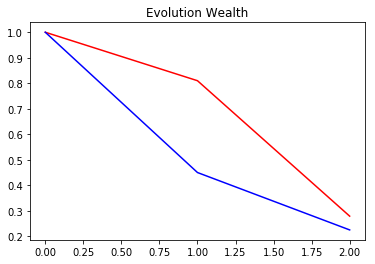

In [23]:
rounds = 2 # amount of rounds
Cr = 0 # initial public good 
population = CreatePopulation(2) # population of players
population[1].behaviour = [[0.1,0.5,0.1],[0.7,0.2,0.5]]
temp = 0
for p in population:
        temp += p.W
for p in population:
        p.total = temp*len(population)

for i in range(rounds):
    temp=0
    print(">>>>Round : ", i+1, "<<<<<")
    for p in population:
        temp += p.Step(Cr)
    Cr+=temp
    print(">>>>Cr : ", Cr, "")
    
    
plt.title('Evolution Wealth')
plt.plot(population[0].history,'r')
plt.plot(population[1].history,'b')
plt.show()

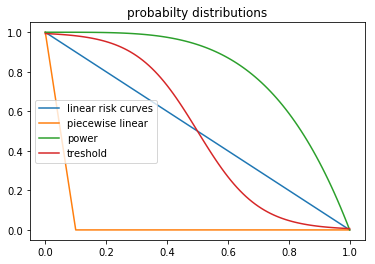

In [75]:
#Risk curves plotting
p1 = lambda Cr :1 -Cr
p2 = lambda Cr: 1-10*Cr if Cr<0.1 else 0
p3 = lambda Cr : 1-math.pow(Cr,4)
p4 = lambda Cr: 1/(math.exp(10*((Cr)-0.5))+1)
xas = np.arange(0.0, 1.01, 0.01)
yas = [ p1(x) for x in xas ]
yas2 = [p2(x) for x in xas] 
yas3 = [p3(x) for x in xas] 
yas4 = [p4(x) for x in xas] 
plt.plot(xas, yas,label = 'linear risk curves')
plt.plot(xas, yas2,label='piecewise linear')
plt.plot(xas, yas3, label = 'power')
plt.plot(xas, yas4, label = 'treshold')
plt.legend()
plt.title('probabilty distributions')
plt.show()